# **Feature Engineering Notebook**

## Objectives

* Engineer features for Classification, Regression and Cluster models

## Inputs

* outputs/datasets/cleaned/TrainSetCleaned.csv
* outputs/datasets/cleaned/TestSetCleaned.csv


## Outputs
* generate a list with variables to engineer

## Conclusions

* Feature Engineering Transformers
  * Ordinal categorical encoding: ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']
  * Ordinal numerical encoding:
    * Log Transformer: ['GrLivArea', 'LotArea']
    * Power Transformer: ['LotFrontage', 'GarageArea', 'MasVnrArea', 'OpenPorchSF', 'TotalBsmtSF', '2ndFlrSF']
    * YeoJohnson Transformer: ['1stFlrSF']
  * Winsorizer & Smart Correlation Selection: ['GrLivArea', 'GarageArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF']


---

# Change working directory

In [1]:
import numpy
import os

In [2]:
current_dir = os.getcwd()
current_dir

'/workspaces/heritage-housing-issues/jupyter_notebooks'

Change the working directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspaces/heritage-housing-issues'

---

# Load Cleanded Data

Train Set

In [5]:
import pandas as pd
TrainSet = pd.read_csv("outputs/datasets/cleaned/TrainSetCleaned.csv")
TrainSet.head()

1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0      1828       0.0      2.883272           Av          48         None   
1       894       0.0      2.000000           No           0          Unf   
2       964       0.0      2.000000           No         713          ALQ   
3      1689       0.0      3.000000           No        1218          GLQ   
4      1541       0.0      3.000000           No           0          Unf   

   BsmtUnfSF  GarageArea GarageFinish  GarageYrBlt  ...  LotArea LotFrontage  \
0       1774         774          Unf       2007.0  ...    11694   90.000000   
1        894         308         None       1962.0  ...     6600   60.000000   
2        163         432          Unf       1921.0  ...    13360   80.000000   
3        350         857          RFn       2002.0  ...    13265   69.614017   
4       1541         843          RFn       2001.0  ...    13704  118.000000   

   MasVnrArea  OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  YearBuilt  \
0       452.0          108            5            9         1822       2007   
1         0.0            0            5            5          894       1962   
2         0.0            0            7            5          876       1921   
3       148.0           59            5            8         1568       2002   
4       150.0           81            5            7         1541       2001   

   YearRemodAdd  SalePrice  
0          2007     314813  
1          1962     109500  
2          2006     163500  
3          2002     271000  
4          2002     205000  

[5 rows x 22 columns]

Test Set

In [6]:
import pandas as pd
TestSet = pd.read_csv("outputs/datasets/cleaned/TestSetCleaned.csv")
TestSet.head()

1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0      2515       0.0           4.0           No        1219          Rec   
1       958     620.0           3.0           No         403          BLQ   
2       979     224.0           3.0           No         185          LwQ   
3      1156     866.0           4.0           No         392          BLQ   
4       525       0.0           3.0           No           0          Unf   

   BsmtUnfSF  GarageArea GarageFinish  GarageYrBlt  ...  LotArea LotFrontage  \
0        816         484         None       1975.0  ...    32668   69.614017   
1        238         240          Unf       1941.0  ...     9490   79.000000   
2        524         352          Unf       1950.0  ...     7015   69.614017   
3        768         505          Fin       1977.0  ...    10005   83.000000   
4        525         264          Unf       1971.0  ...     1680   21.000000   

   MasVnrArea  OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  YearBuilt  \
0         0.0            0            3            6         2035       1957   
1         0.0            0            7            6          806       1941   
2       161.0            0            4            5          709       1950   
3       299.0          117            5            7         1160       1977   
4       381.0            0            5            6          525       1971   

   YearRemodAdd  SalePrice  
0          1975     200624  
1          1950     133000  
2          1950     110000  
3          1977     192000  
4          1971      88000  

[5 rows x 22 columns]

# Data Exploration

Check variable types and distribution, missing levels and what these variables mean in a business context

In [7]:
from ydata_profiling import ProfileReport
pandas_report = ProfileReport(df=TrainSet, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Feature Engineering

## Custom function

This function is a custom feature engineering tool that applies a set of feature engineering transformers based on the user's selected analysis type, which can be numeric, ordinal or outlier.

In [8]:
# Code taken from walktrough Project 02 - Churnometer
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like ydata-profiling, to evaluate distributions
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        if analysis_type != 'ordinal_encoder':
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=[
                  '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[
                                 f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")

    except Exception:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked

---

## Feature Engineering Summary

* The transformers to be taken into account are:
  * Categorical Encoding
  * Numerical Transformation
  * outlier winsorizer
  * Smart Correlation Selectionion

## Dealing with Feature Engineering

### Categorical Encoding - Ordinal: replaces categories with ordinal numbers

* Step 1: Select variable(s)

In [9]:
variables_engineering= ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']
variables_engineering

['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']

* Step 2: Create a separate DataFrame, with your variable(s)

In [10]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head()

BsmtExposure BsmtFinType1 GarageFinish KitchenQual
0           Av         None          Unf          Gd
1           No          Unf         None          TA
2           No          ALQ          Unf          TA
3           No          GLQ          RFn          Gd
4           No          Unf          RFn          Gd

* Step 3: Create engineered variables(s) by applying the transformation(s), assess engineered variables distribution and select the most suitable method for each variable.

* Variable Analyzed: BsmtExposure
* Applied transformation: ['BsmtExposure_ordinal_encoder'] 



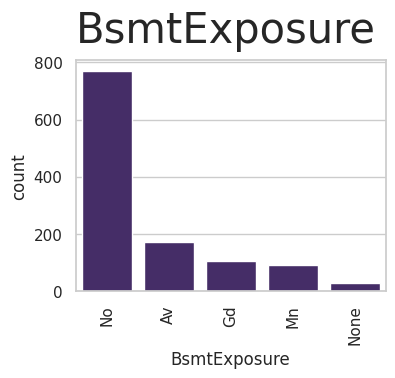

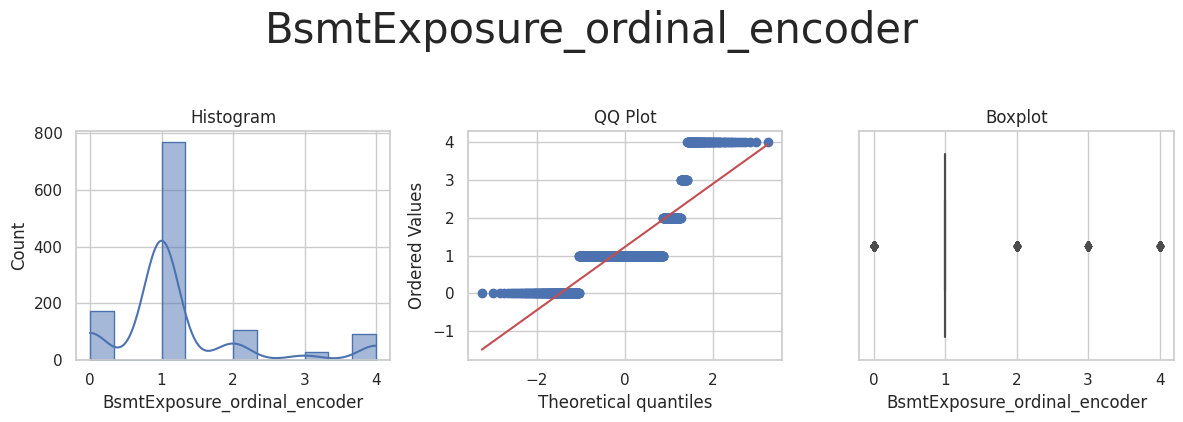



* Variable Analyzed: BsmtFinType1
* Applied transformation: ['BsmtFinType1_ordinal_encoder'] 



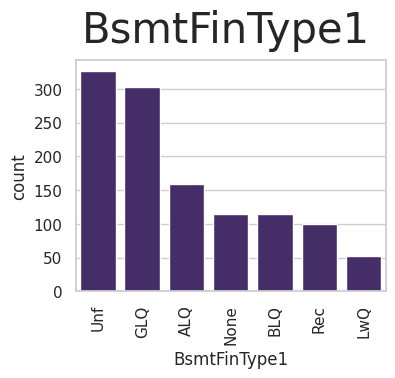

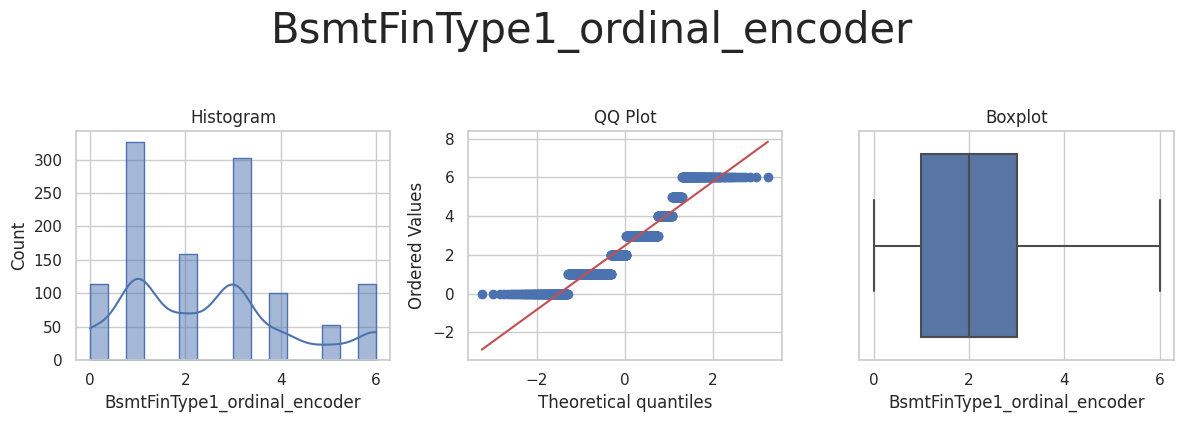



* Variable Analyzed: GarageFinish
* Applied transformation: ['GarageFinish_ordinal_encoder'] 



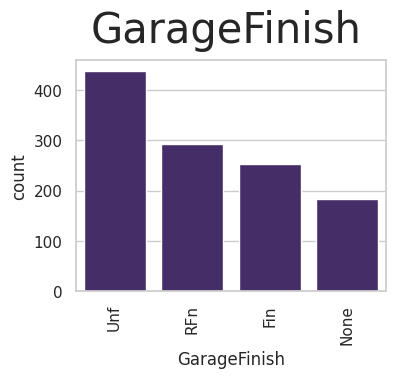

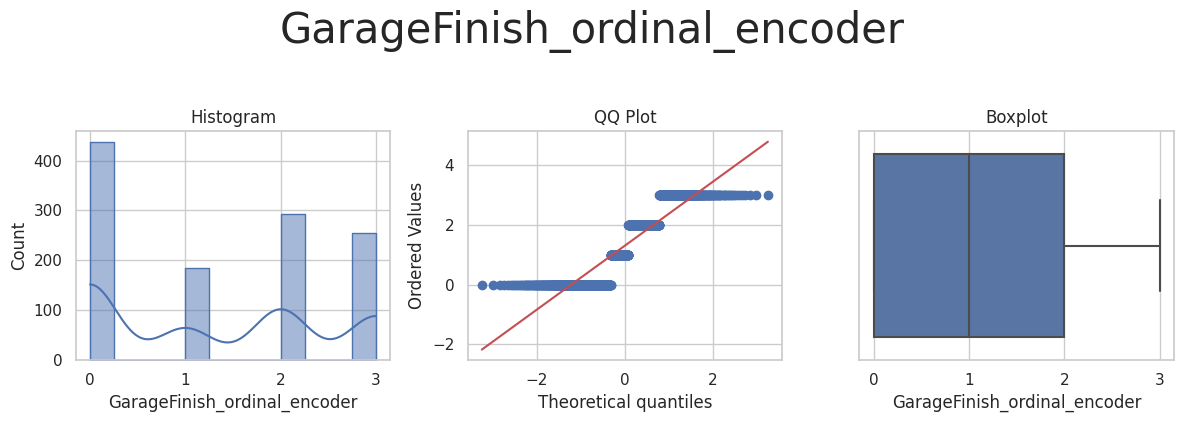



* Variable Analyzed: KitchenQual
* Applied transformation: ['KitchenQual_ordinal_encoder'] 



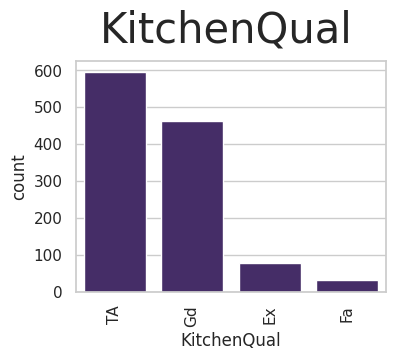

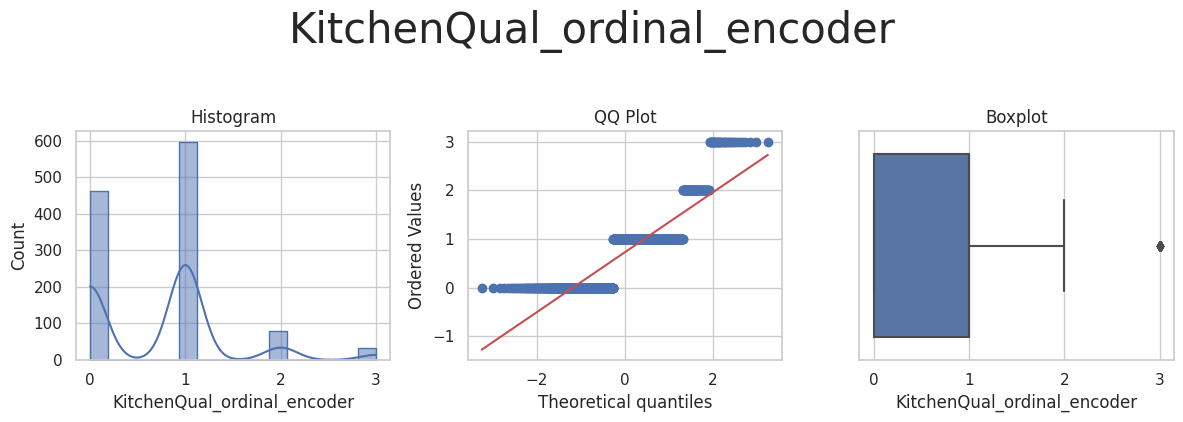

In [11]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='ordinal_encoder')

* Step 4 - Apply the selected transformation to the Train and Test set

In [12]:
# Code taken from walktrough Project 02 - Churnometer
encoder = OrdinalEncoder(encoding_method='arbitrary', variables = variables_engineering)
TrainSet = encoder.fit_transform(TrainSet)
TestSet = encoder.transform(TestSet)

print("* Categorical encoding - ordinal transformation done!")

* Categorical encoding - ordinal transformation done!


### Numerical Transformation

In [17]:
variables_engineering = ['GrLivArea', 'LotArea', 'LotFrontage', 'GarageArea', 'MasVnrArea', 'OpenPorchSF', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF1', '1stFlrSF', '2ndFlrSF']
variables_engineering

['GrLivArea',
 'LotArea',
 'LotFrontage',
 'GarageArea',
 'MasVnrArea',
 'OpenPorchSF',
 'TotalBsmtSF',
 'BsmtUnfSF',
 'BsmtFinSF1',
 '1stFlrSF',
 '2ndFlrSF']

In [18]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head()

GrLivArea   LotArea  LotFrontage  GarageArea  MasVnrArea  OpenPorchSF  \
0   7.510978  9.366831     9.486833   27.820855   21.260292    10.392305   
1   6.795706  8.794825     7.745967   17.549929    0.000000     0.000000   
2   6.871091  9.500020     8.944272   20.784610    0.000000     0.000000   
3   7.431892  9.492884     8.343501   29.274562   12.165525     7.681146   
4   7.340187  9.525443    10.862780   29.034462   12.247449     9.000000   

   TotalBsmtSF  BsmtUnfSF  BsmtFinSF1  1stFlrSF  2ndFlrSF  
0    42.684892       1774          48  7.585316       0.0  
1    29.899833        894           0  6.857203       0.0  
2    29.597297        163         713  6.933857       0.0  
3    39.597980        350        1218  7.504725       0.0  
4    39.255573       1541           0  7.411301       0.0

* Variable Analyzed: GrLivArea
* Applied transformation: ['GrLivArea_log_e', 'GrLivArea_log_10', 'GrLivArea_reciprocal', 'GrLivArea_power', 'GrLivArea_box_cox', 'GrLivArea_yeo_johnson'] 



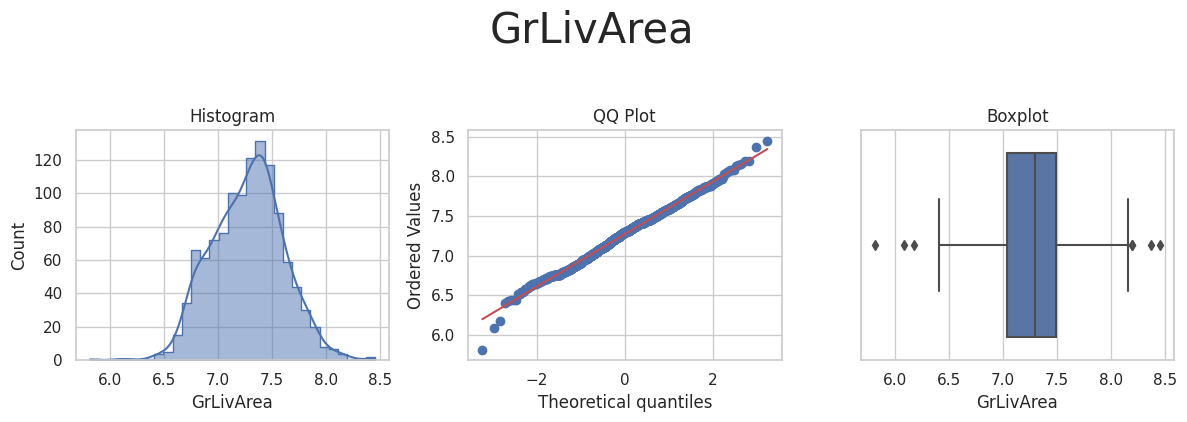

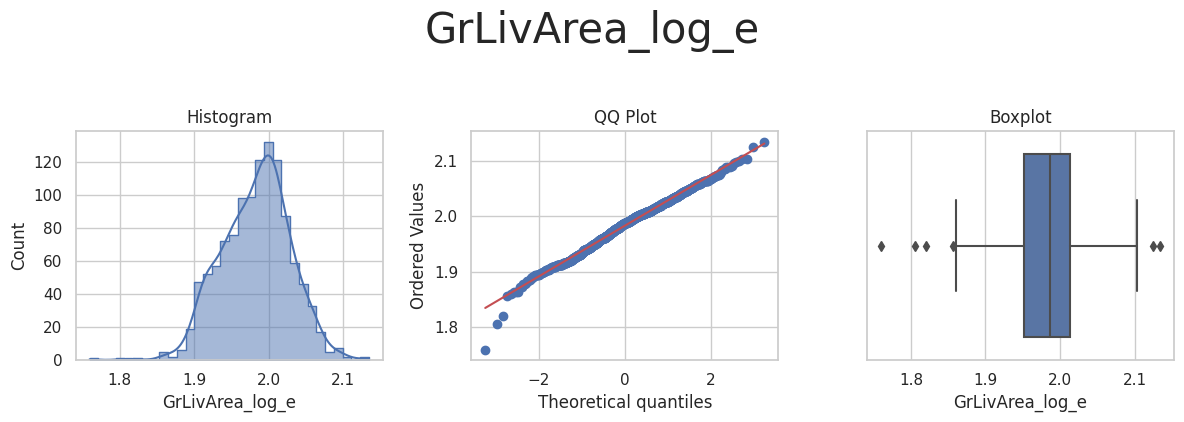

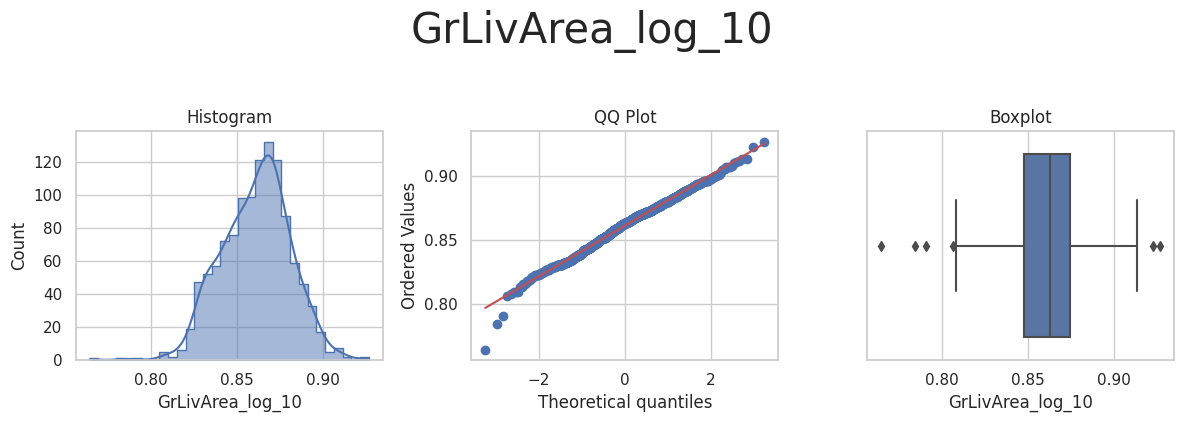

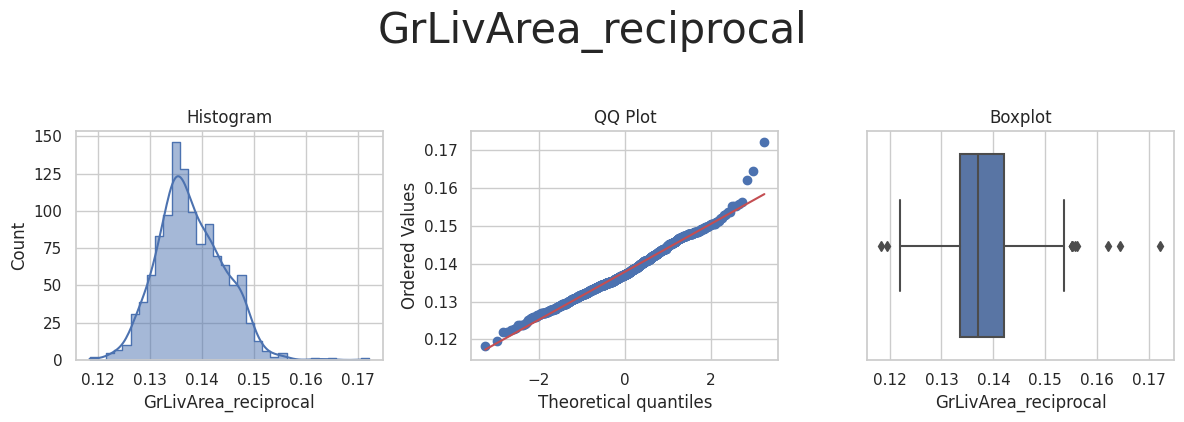

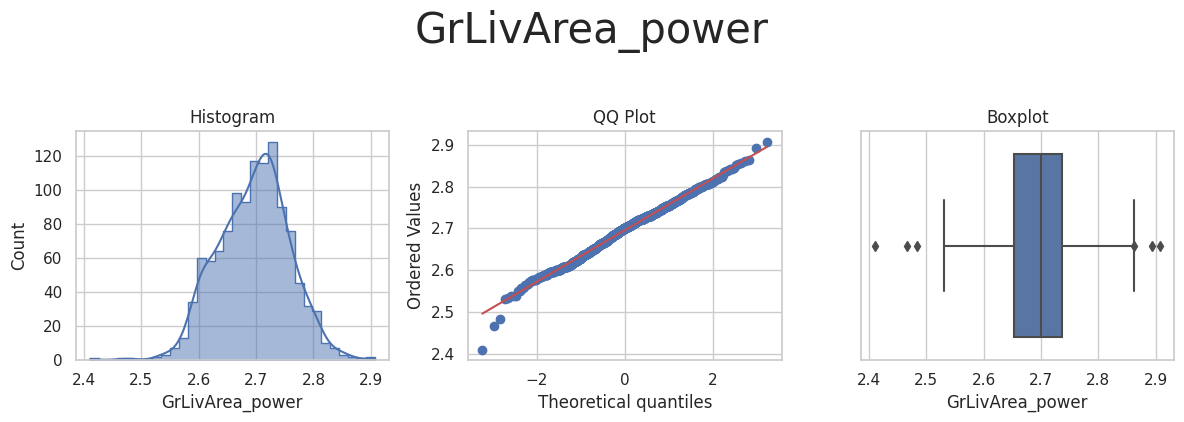

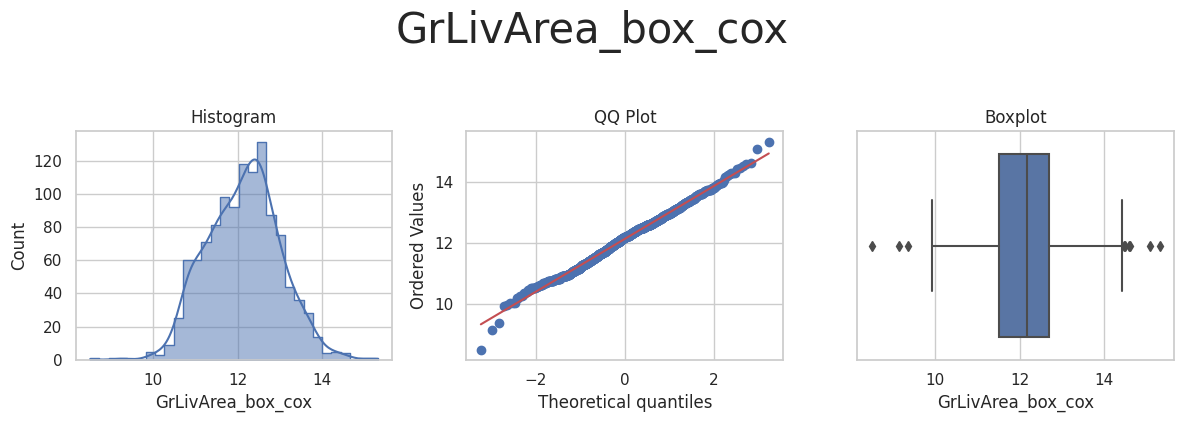

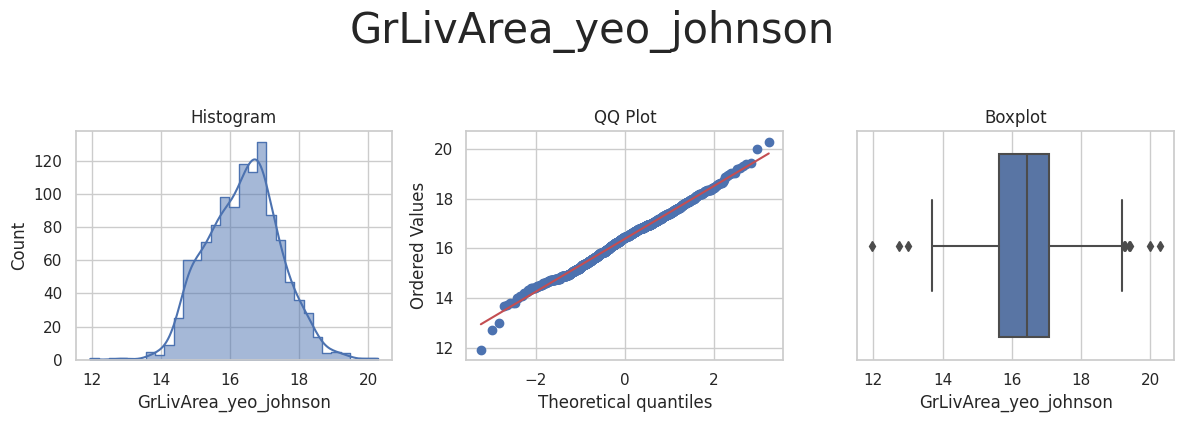



* Variable Analyzed: LotArea
* Applied transformation: ['LotArea_log_e', 'LotArea_log_10', 'LotArea_reciprocal', 'LotArea_power', 'LotArea_box_cox', 'LotArea_yeo_johnson'] 



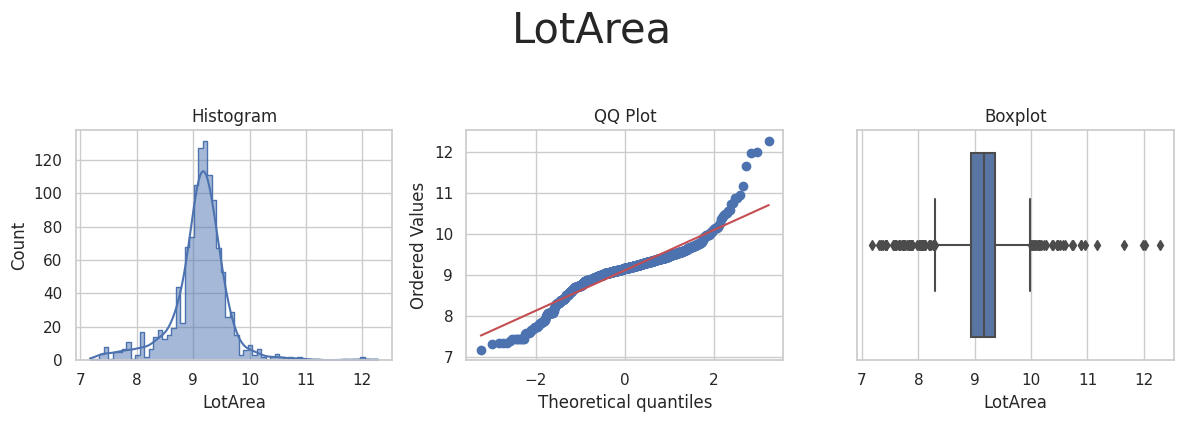

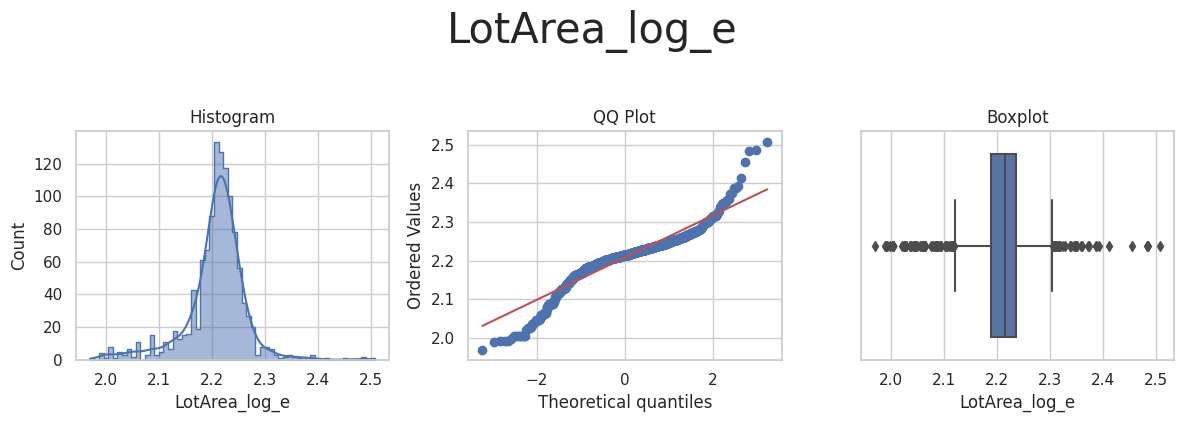

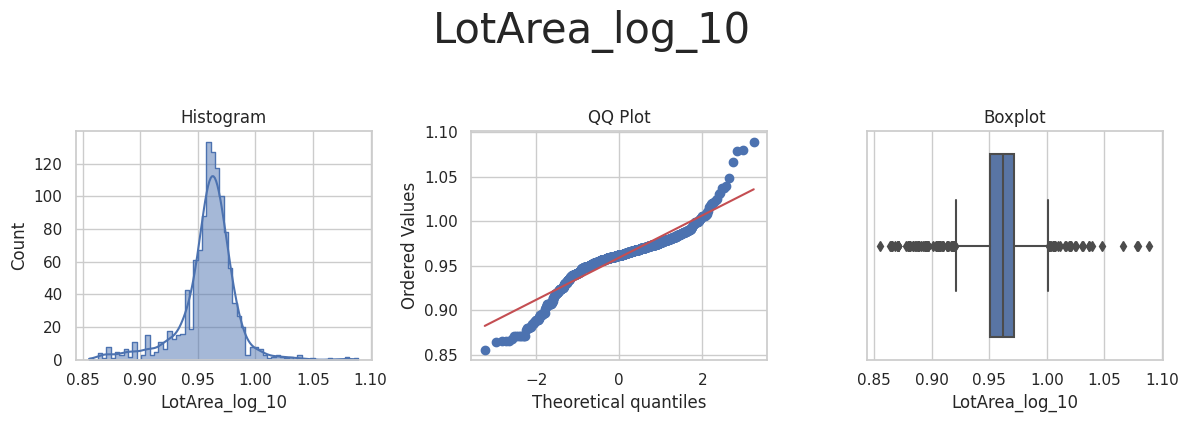

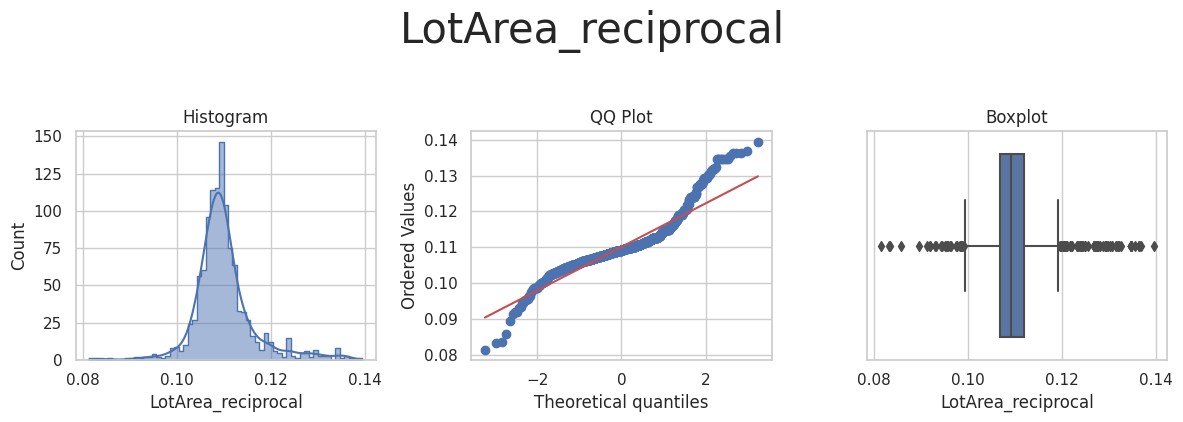

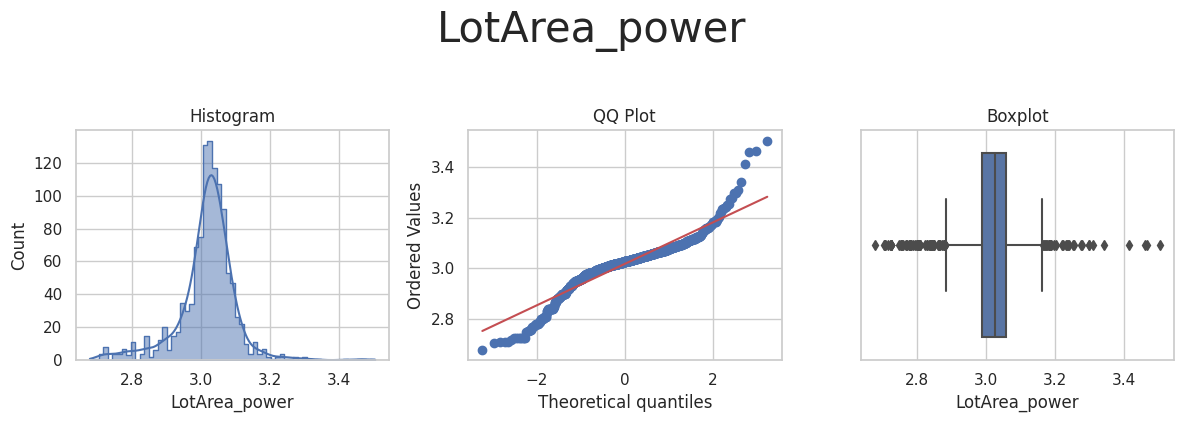

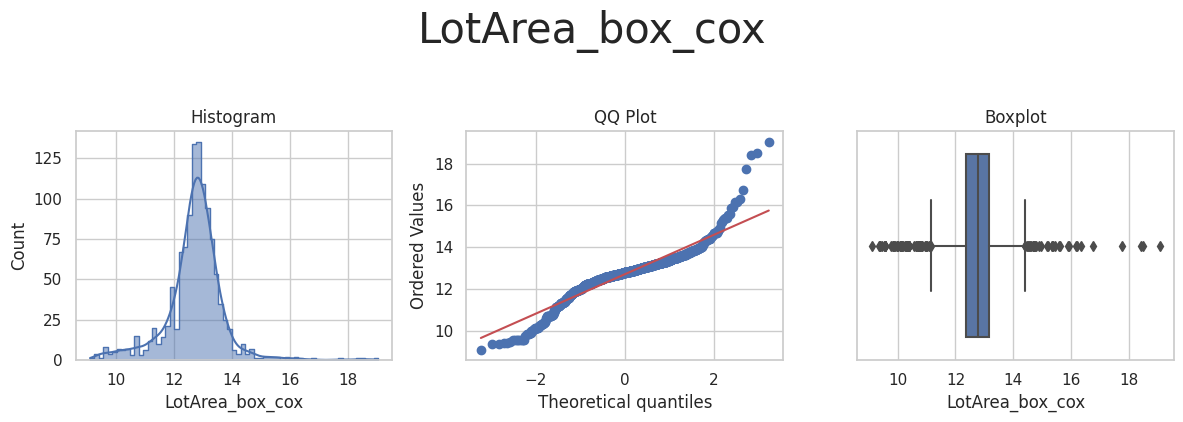

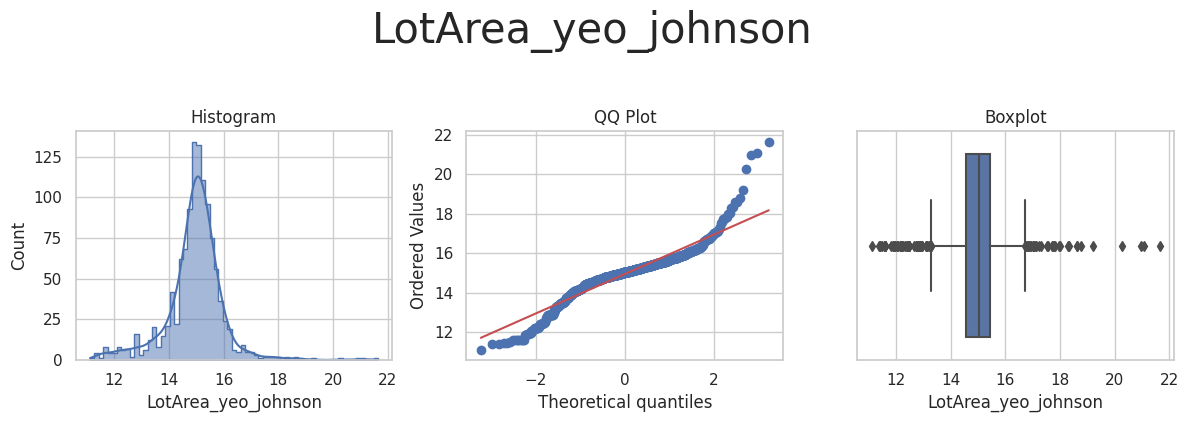



* Variable Analyzed: LotFrontage
* Applied transformation: ['LotFrontage_log_e', 'LotFrontage_log_10', 'LotFrontage_reciprocal', 'LotFrontage_power', 'LotFrontage_box_cox', 'LotFrontage_yeo_johnson'] 



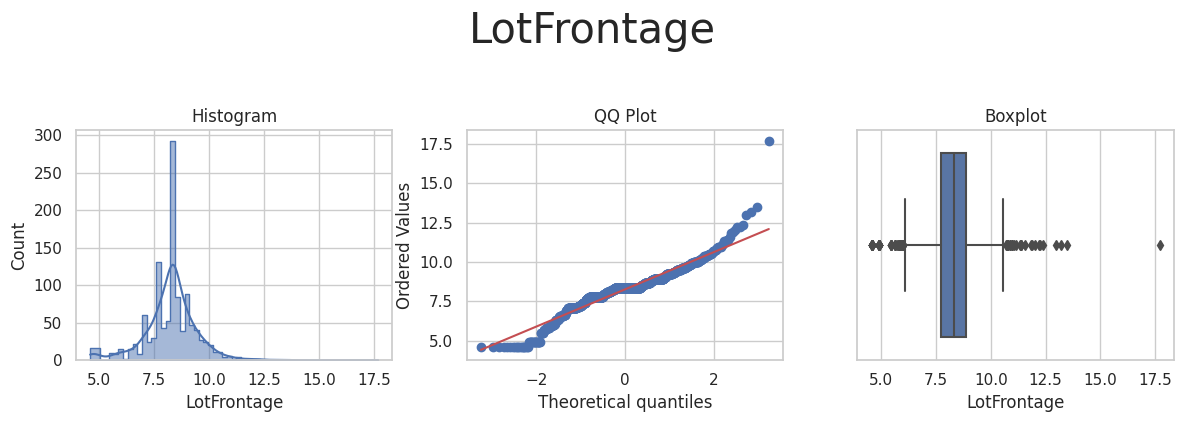

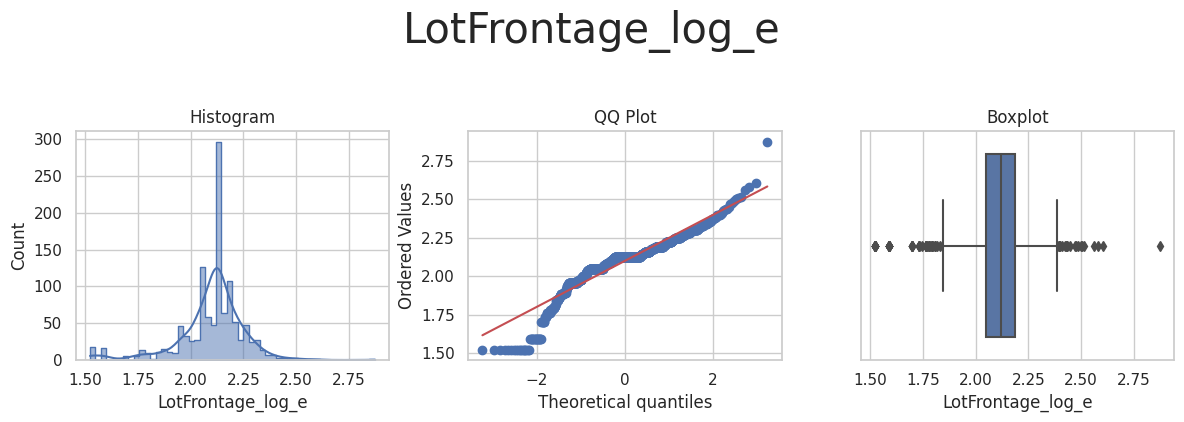

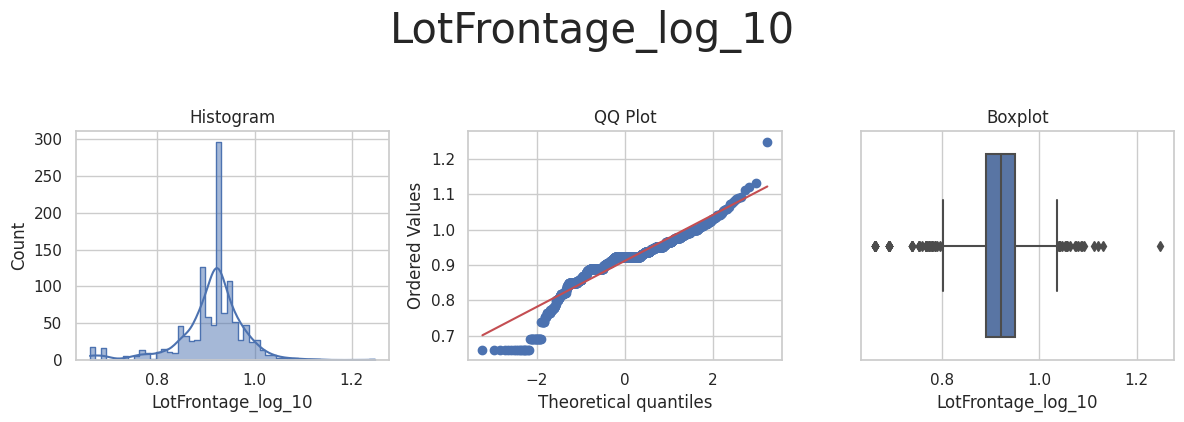

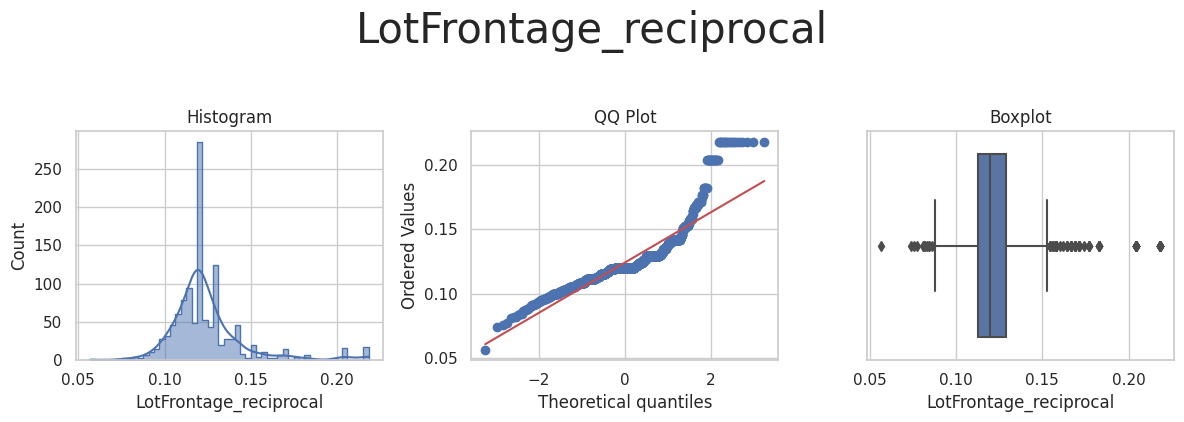

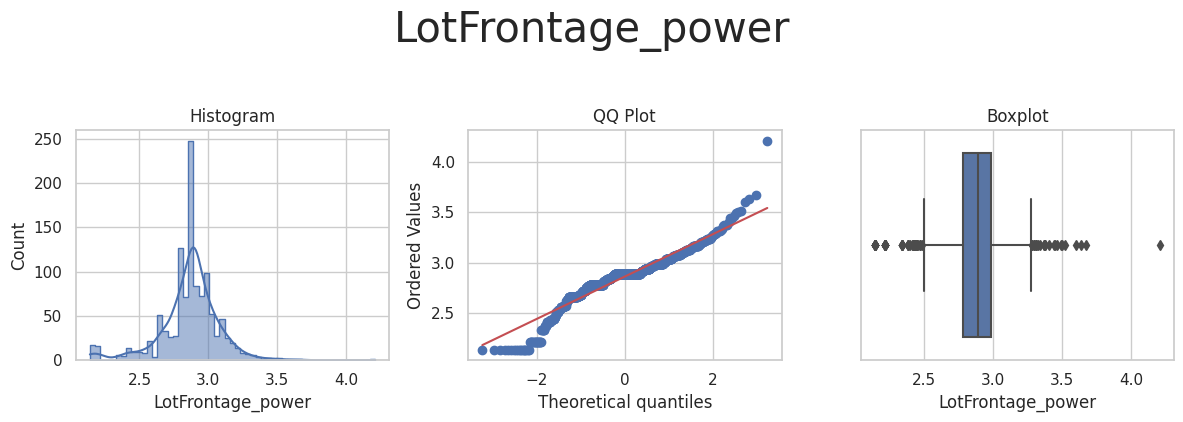

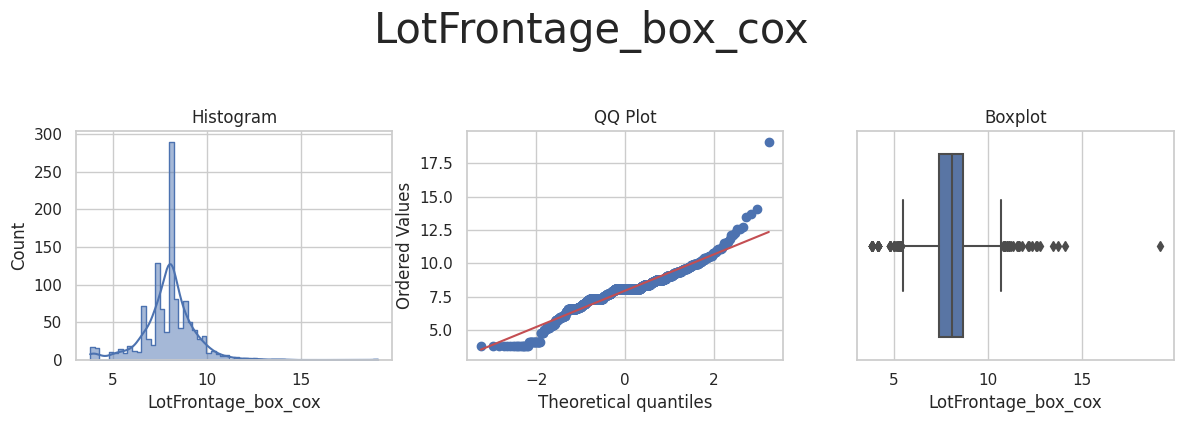

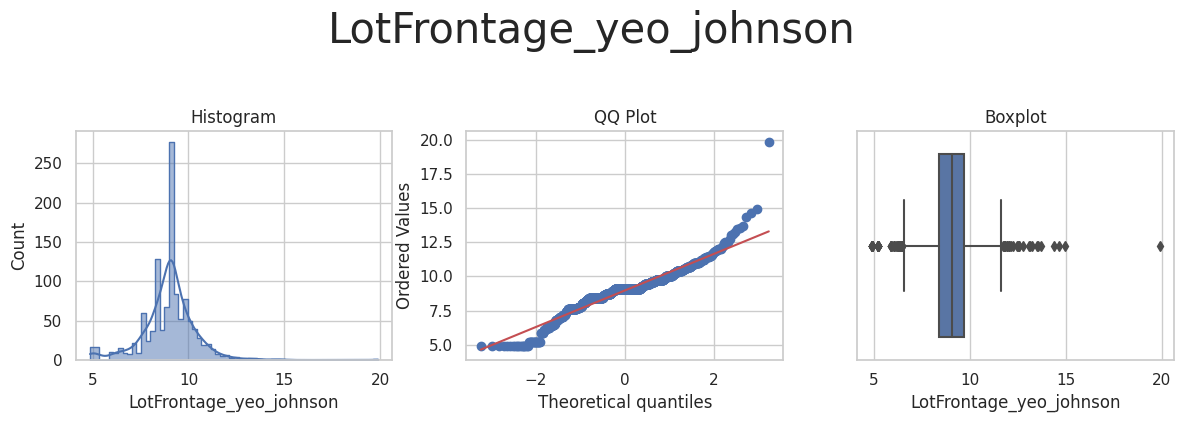



* Variable Analyzed: GarageArea
* Applied transformation: ['GarageArea_power', 'GarageArea_yeo_johnson'] 



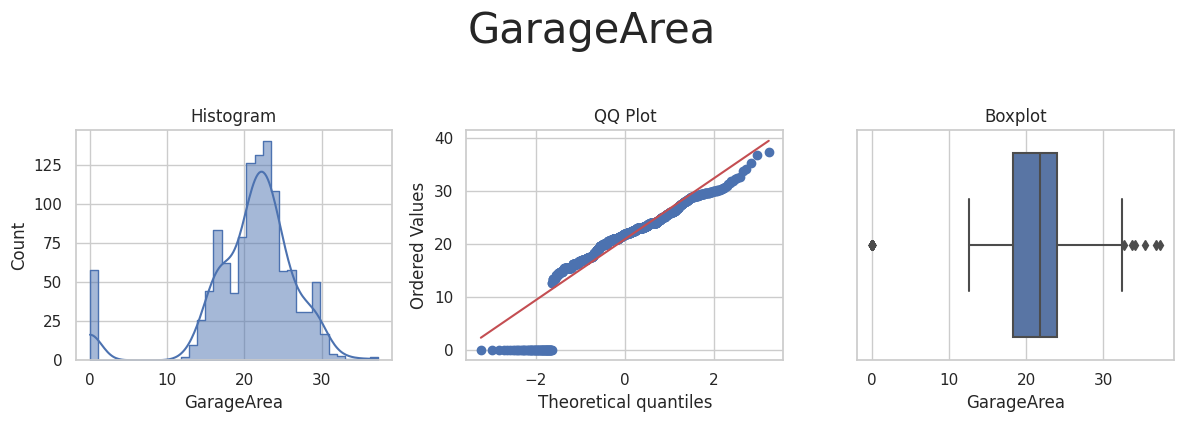

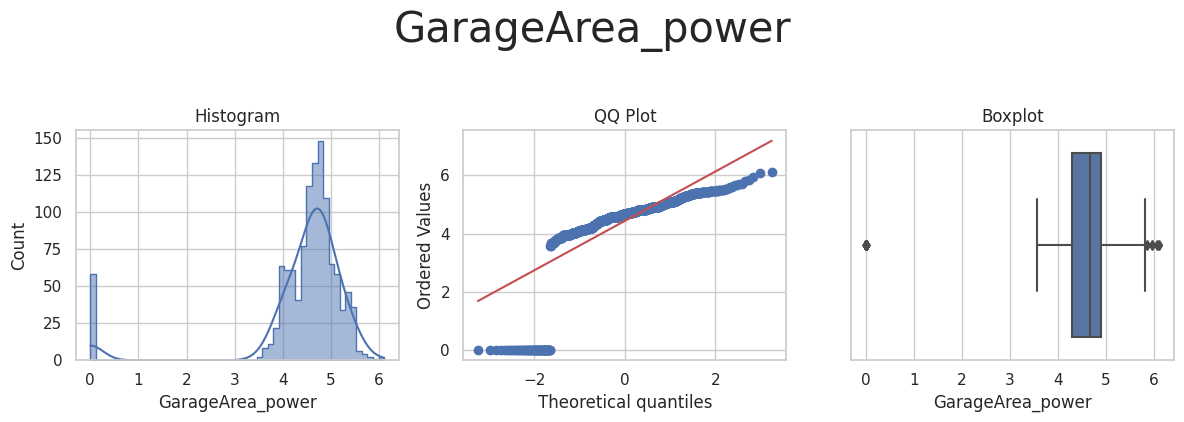

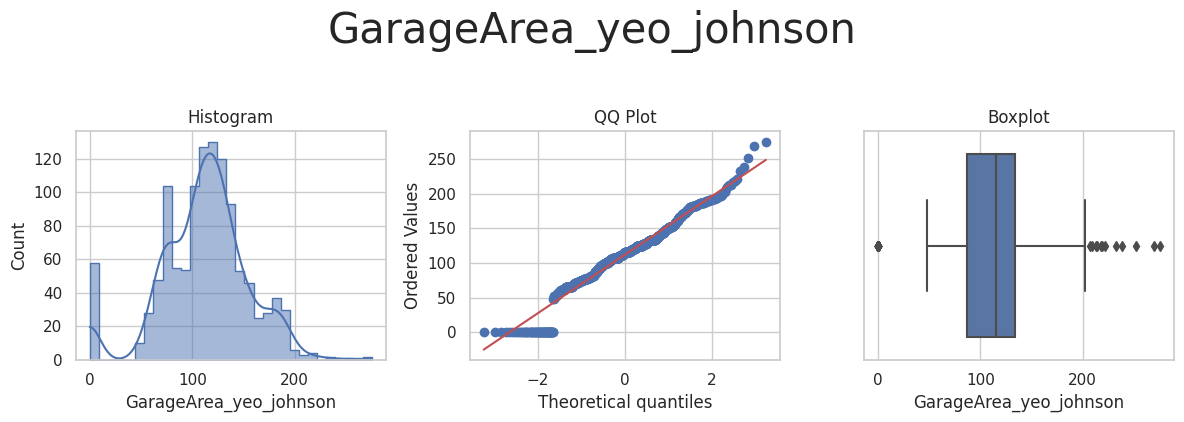



* Variable Analyzed: MasVnrArea
* Applied transformation: ['MasVnrArea_power', 'MasVnrArea_yeo_johnson'] 



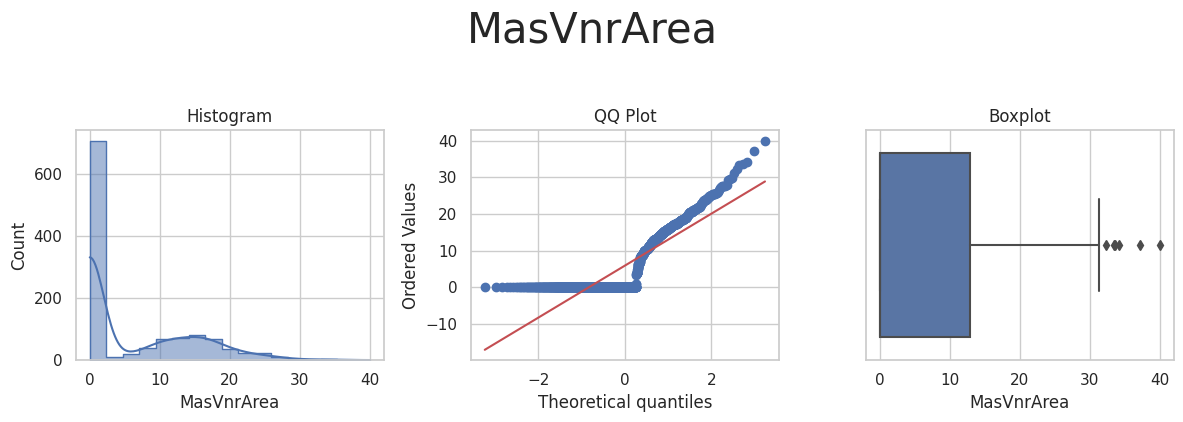

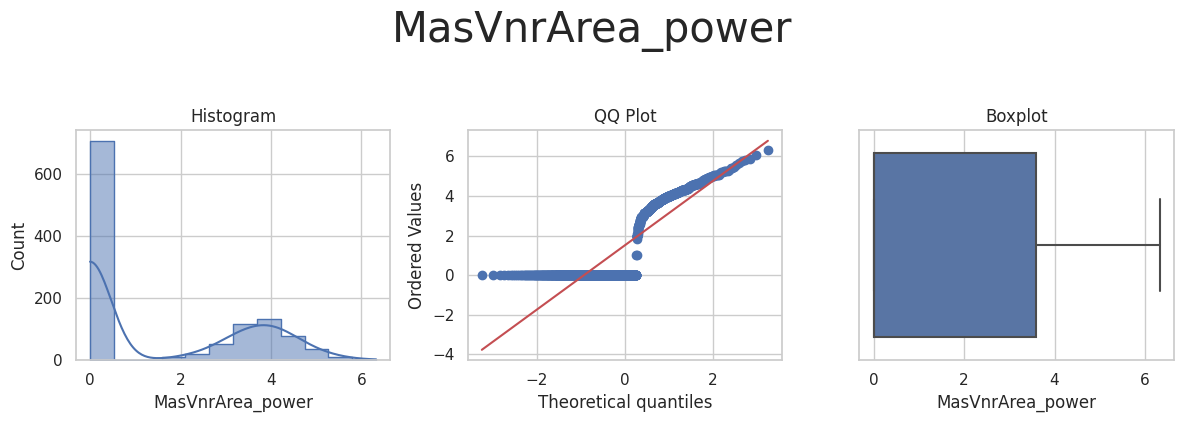

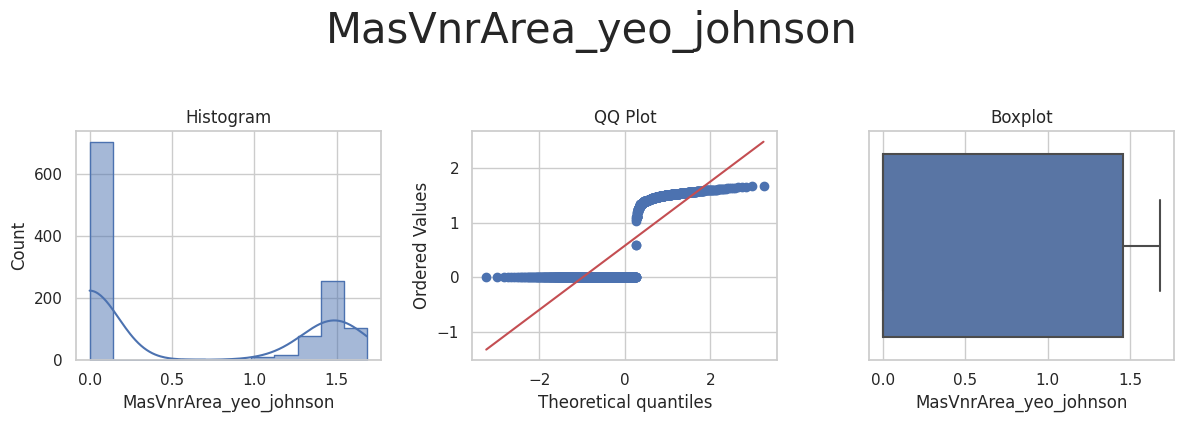



* Variable Analyzed: OpenPorchSF
* Applied transformation: ['OpenPorchSF_power', 'OpenPorchSF_yeo_johnson'] 



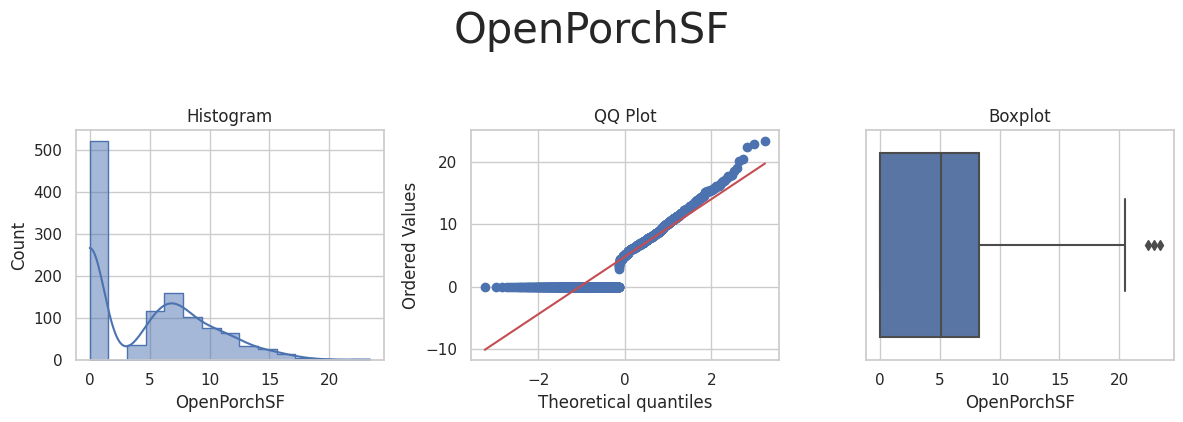

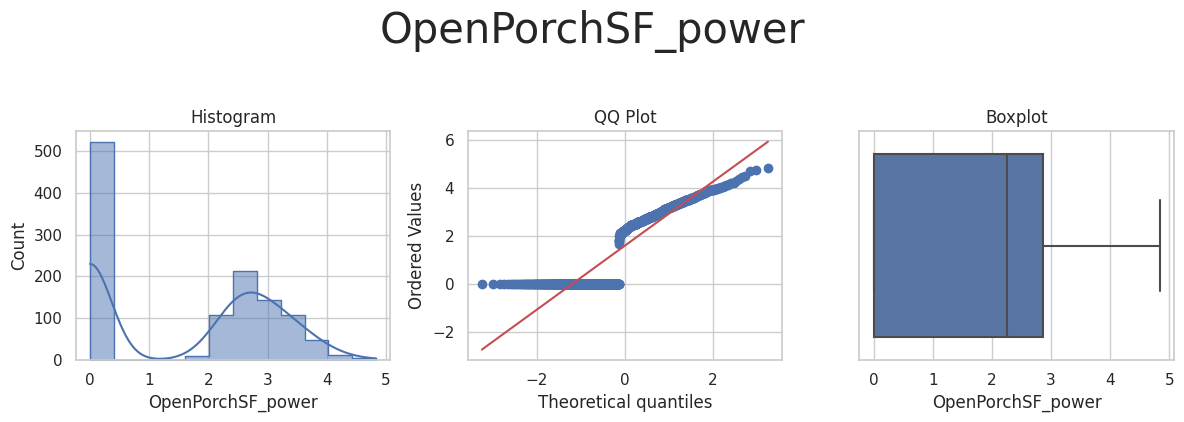

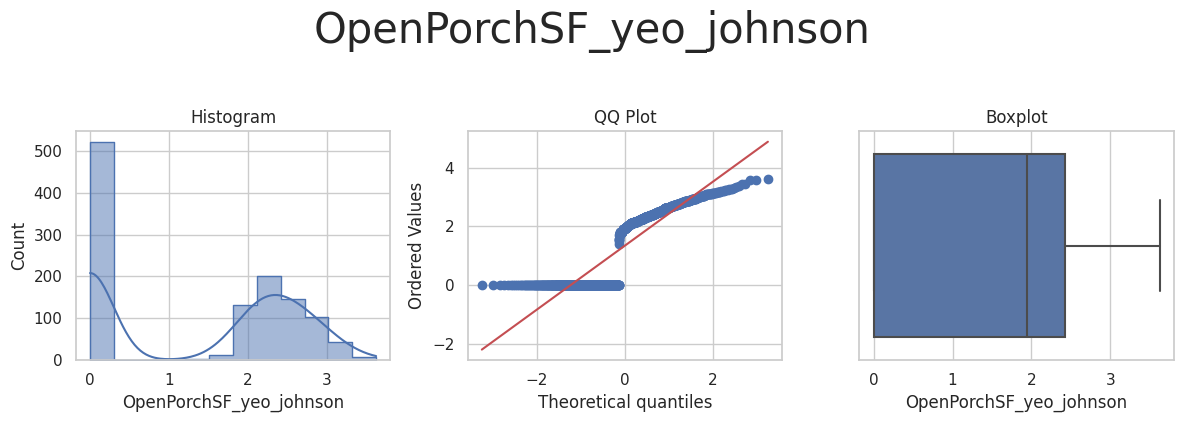



* Variable Analyzed: TotalBsmtSF
* Applied transformation: ['TotalBsmtSF_power', 'TotalBsmtSF_yeo_johnson'] 



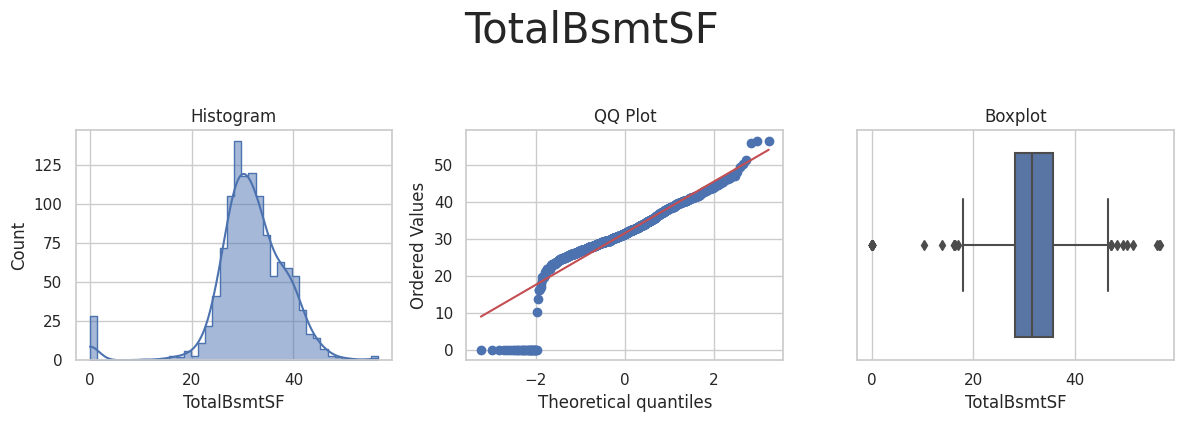

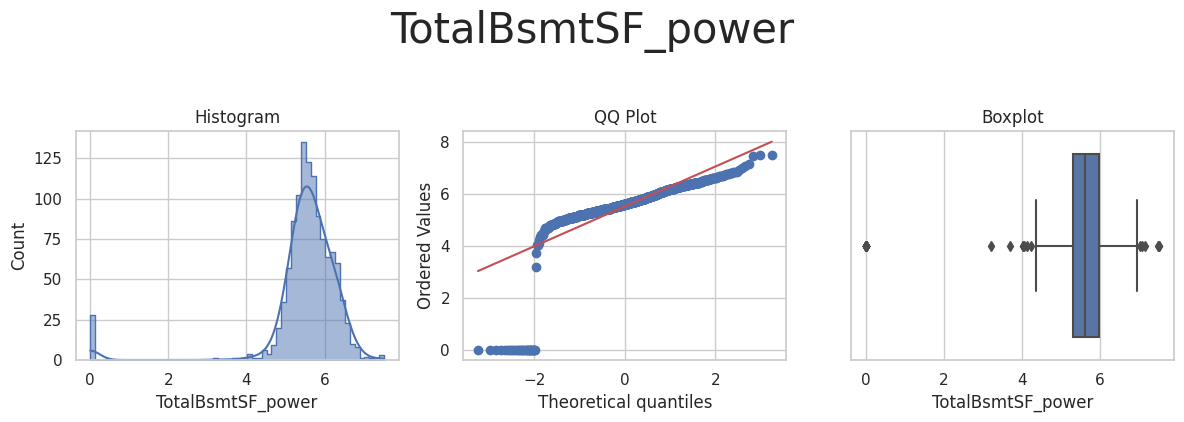

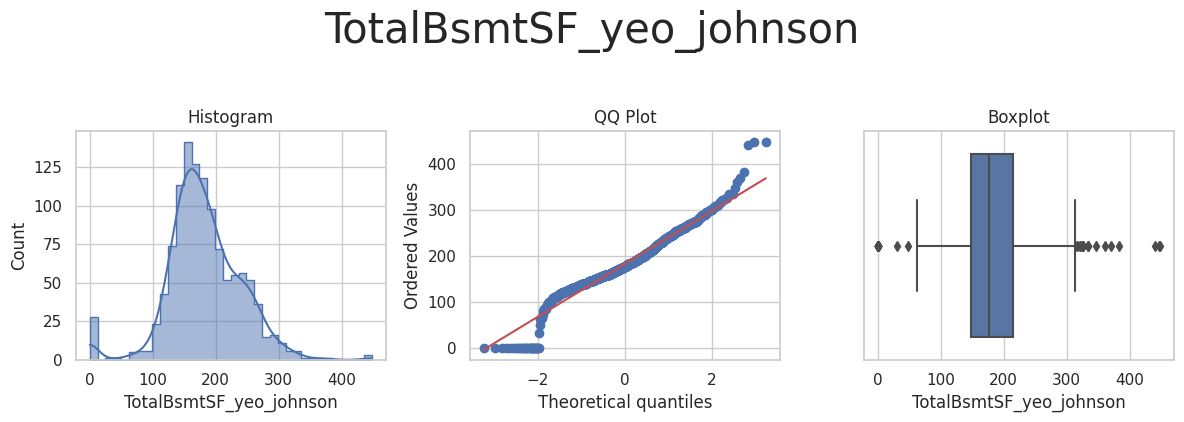



* Variable Analyzed: BsmtUnfSF
* Applied transformation: ['BsmtUnfSF_power', 'BsmtUnfSF_yeo_johnson'] 



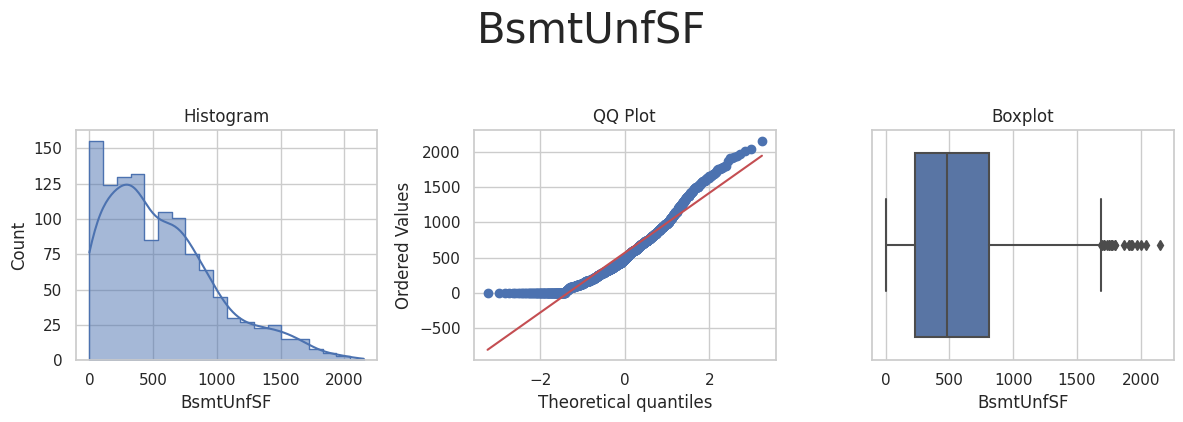

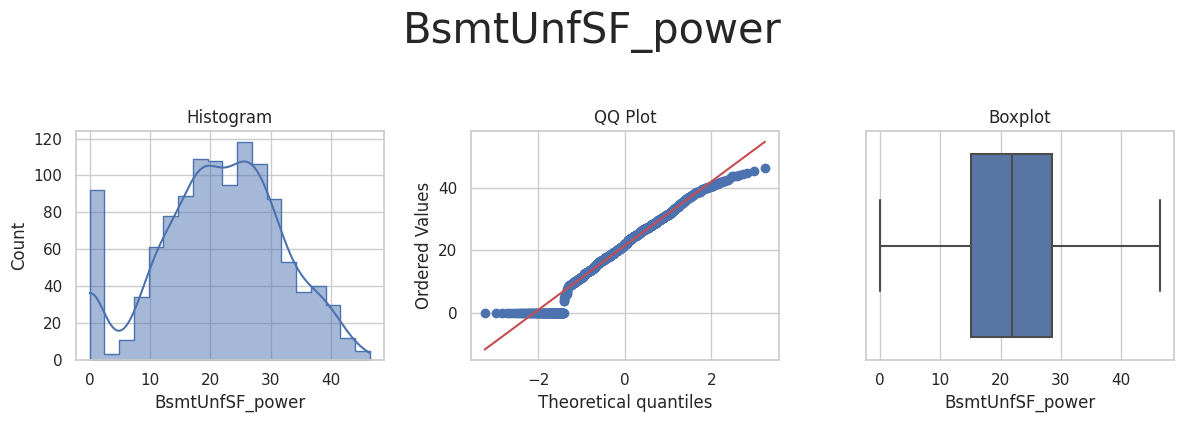

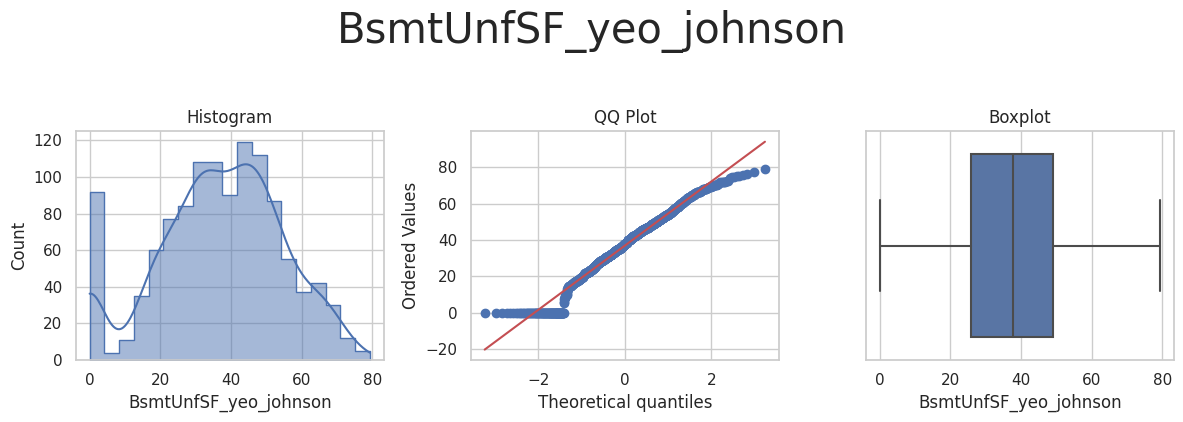



* Variable Analyzed: BsmtFinSF1
* Applied transformation: ['BsmtFinSF1_power', 'BsmtFinSF1_yeo_johnson'] 



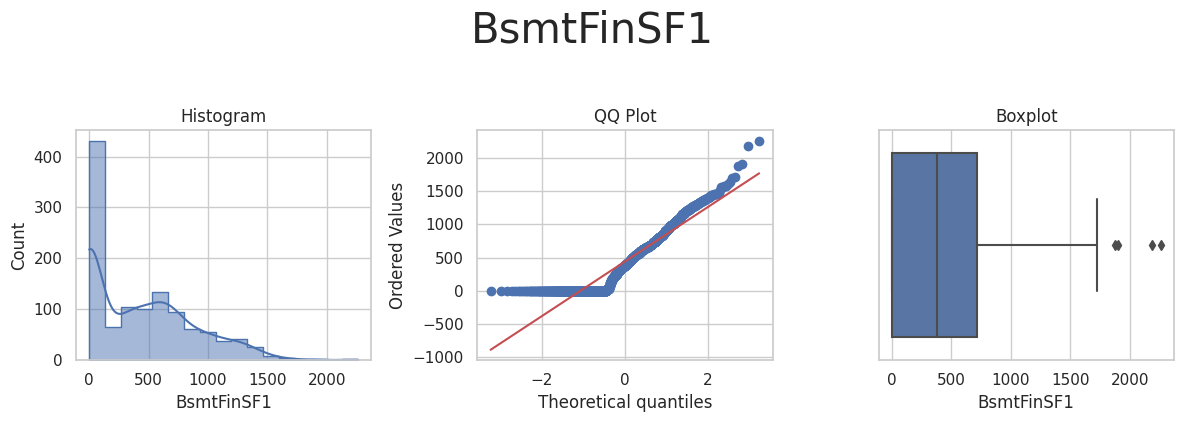

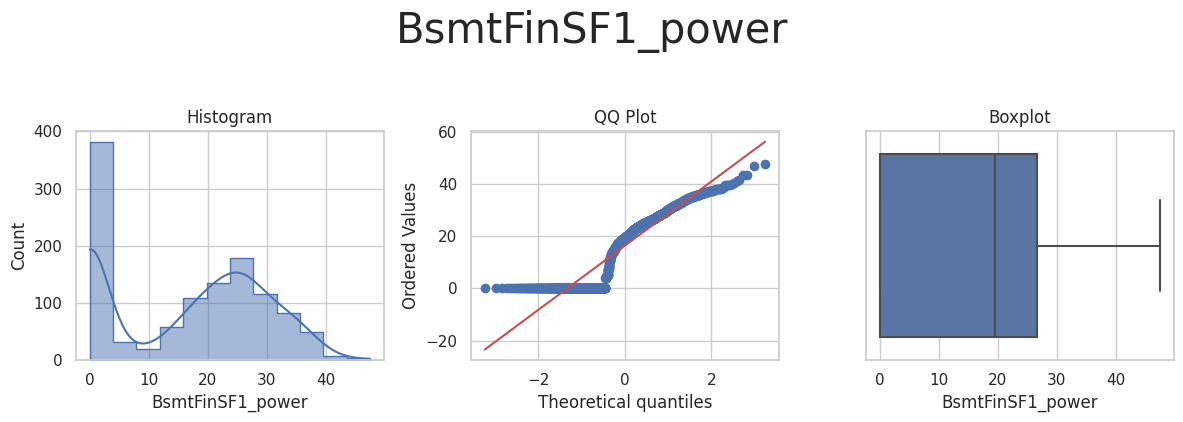

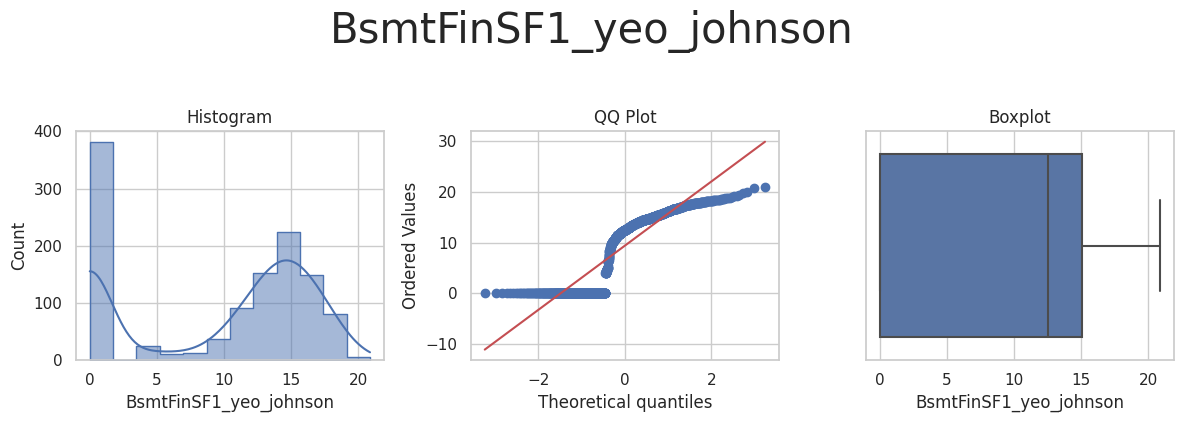



* Variable Analyzed: 1stFlrSF
* Applied transformation: ['1stFlrSF_log_e', '1stFlrSF_log_10', '1stFlrSF_reciprocal', '1stFlrSF_power', '1stFlrSF_box_cox', '1stFlrSF_yeo_johnson'] 



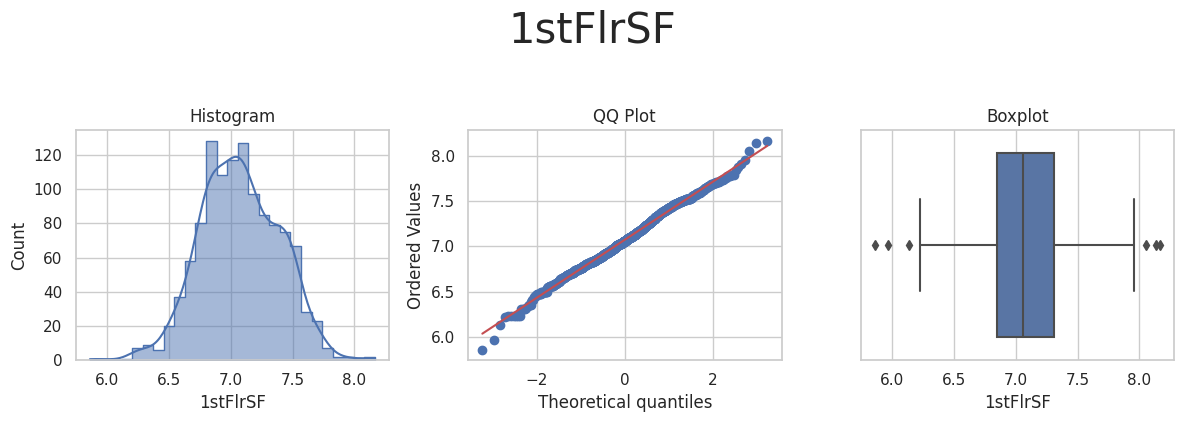

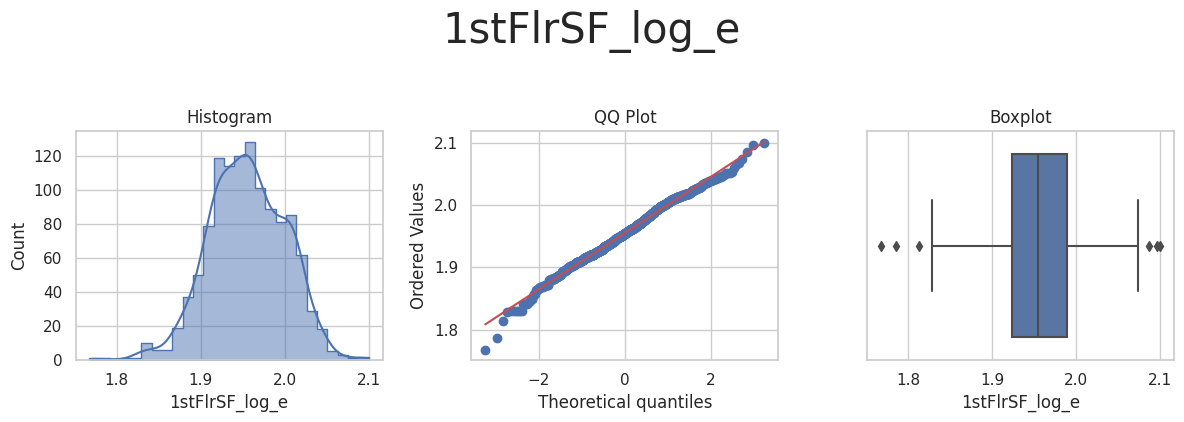

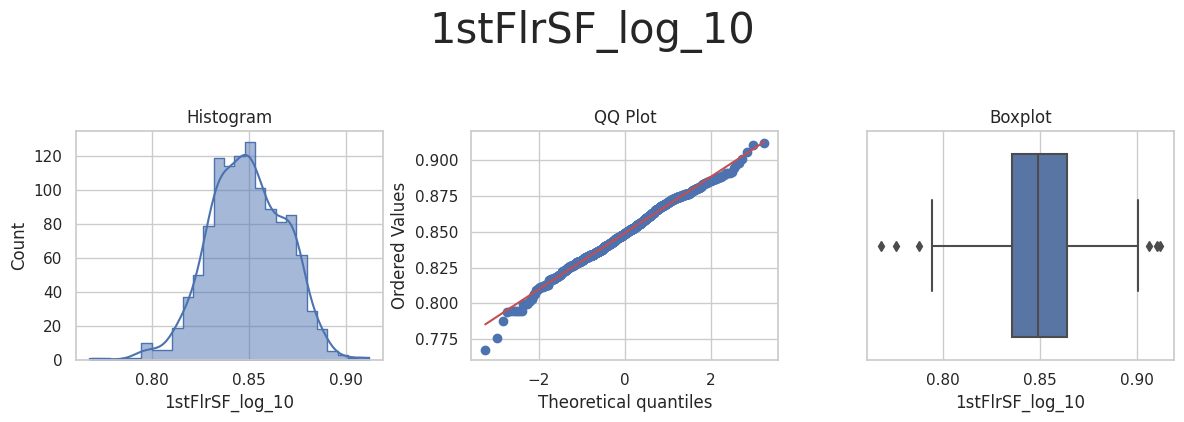

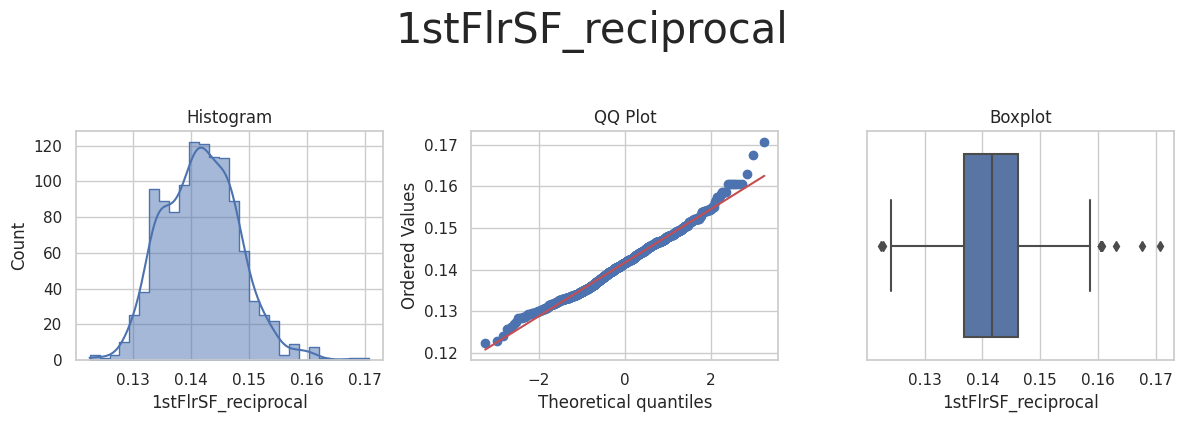

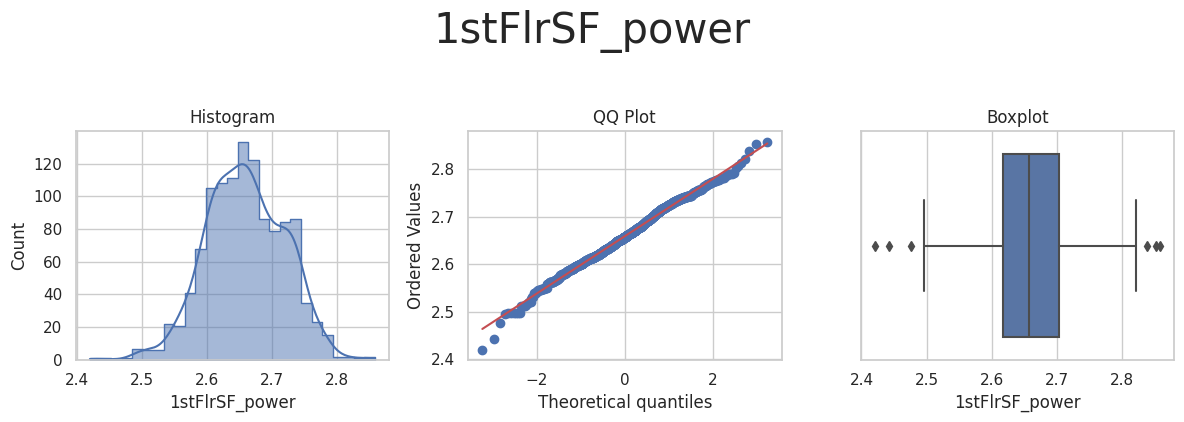

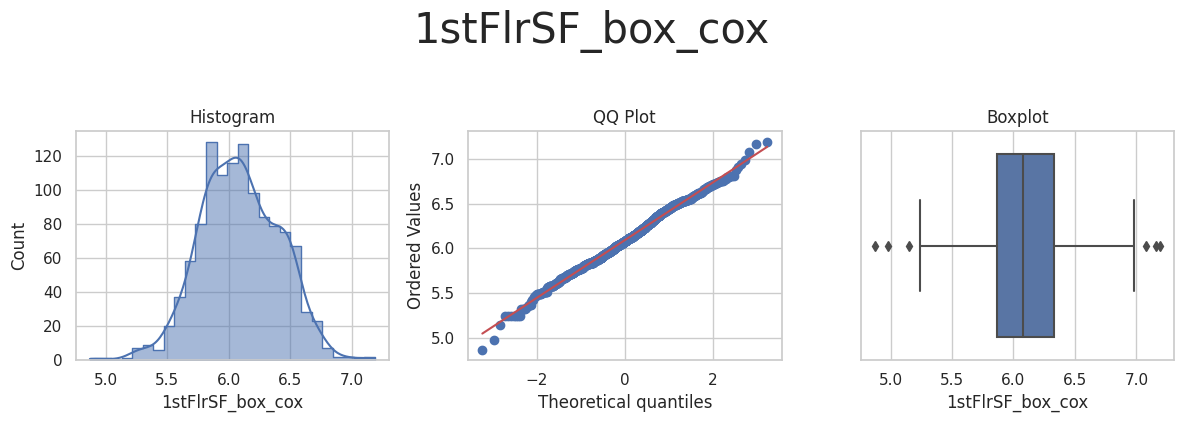

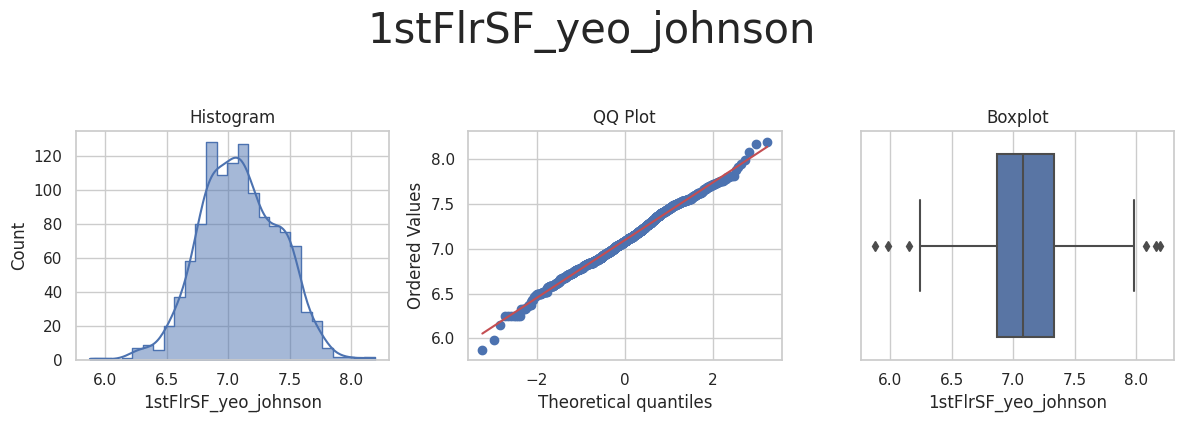



* Variable Analyzed: 2ndFlrSF
* Applied transformation: ['2ndFlrSF_power', '2ndFlrSF_yeo_johnson'] 



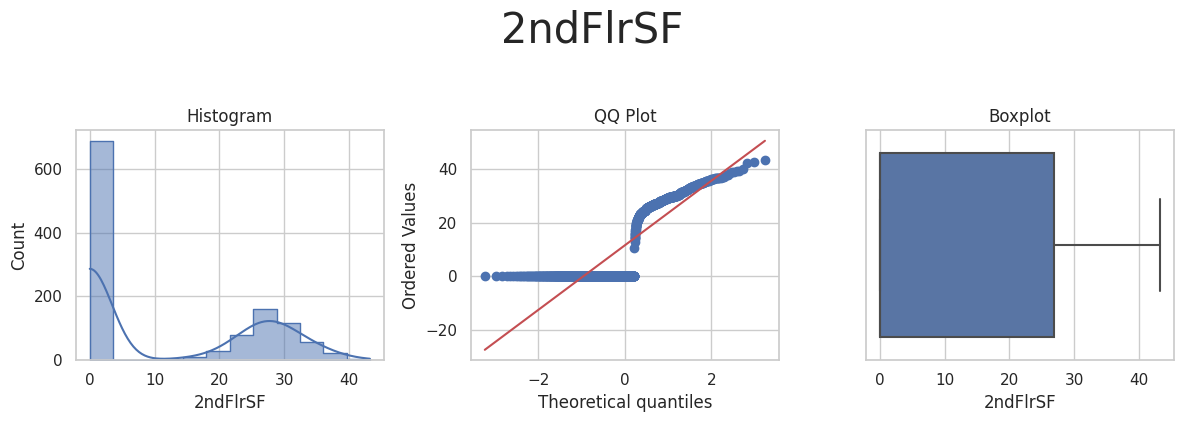

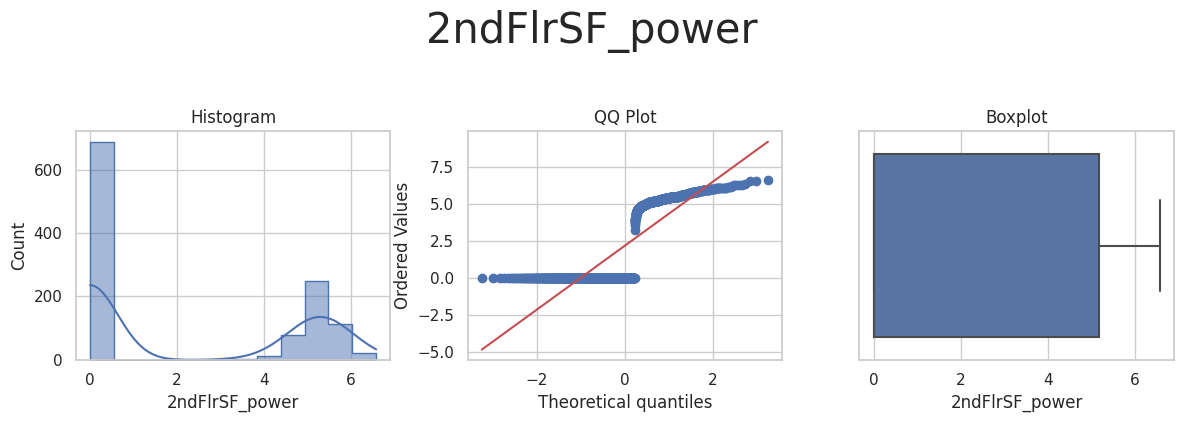

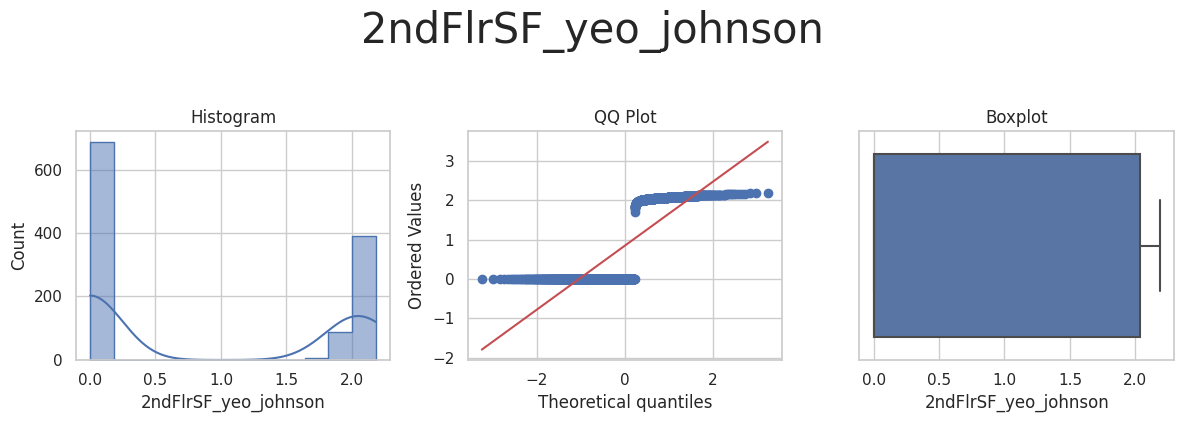

In [19]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='numerical')

In [20]:
# Code taken and modified from repository: heritage-housing-issues - Amareteklay & Imangnp
lt = vt.LogTransformer(variables = ['GrLivArea', 'LotArea'])
pt = vt.PowerTransformer(variables = ['LotFrontage', 'GarageArea', 'MasVnrArea', 'OpenPorchSF', 'TotalBsmtSF', '2ndFlrSF'])
yj = vt.YeoJohnsonTransformer(variables = ['1stFlrSF'])

transformers = [lt, pt, yj]
for t in transformers:
    TrainSet = t.fit_transform(TrainSet)
    TestSet = t.fit_transform(TestSet)

print("* Numerical transformation done!")

* Numerical transformation done!


### Winsorizer

In [21]:
variables_engineering = ['GrLivArea', 'GarageArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF']

encoder = Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=variables_engineering)

TrainSet=encoder.fit_transform(TrainSet)
TestSet=encoder.fit_transform(TestSet)

print("* Outlier winsorizer transformation done!")

* Outlier winsorizer transformation done!


### Smart Correlated Selection

In [24]:
variables_engineering = (TrainSet.select_dtypes(include=['float', 'int']).columns.to_list())
variables_engineering.remove('SalePrice')
variables_engineering

['1stFlrSF',
 '2ndFlrSF',
 'BedroomAbvGr',
 'BsmtExposure',
 'BsmtFinSF1',
 'BsmtFinType1',
 'BsmtUnfSF',
 'GarageArea',
 'GarageFinish',
 'GarageYrBlt',
 'GrLivArea',
 'KitchenQual',
 'LotArea',
 'LotFrontage',
 'MasVnrArea',
 'OpenPorchSF',
 'OverallCond',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd']

In [25]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head()

1stFlrSF  2ndFlrSF  BedroomAbvGr  BsmtExposure  BsmtFinSF1  BsmtFinType1  \
0  7.609511       0.0      2.883272             0          48             0   
1  6.877984       0.0      2.000000             1           0             1   
2  6.954991       0.0      2.000000             1         713             2   
3  7.528536       0.0      3.000000             1        1218             3   
4  7.434667       0.0      3.000000             1           0             1   

   BsmtUnfSF  GarageArea  GarageFinish  GarageYrBlt  ...  KitchenQual  \
0       1774    5.274548             0       2007.0  ...            0   
1        894    4.189264             1       1962.0  ...            1   
2        163    4.559014             0       1921.0  ...            1   
3        350    5.410597             2       2002.0  ...            0   
4       1541    5.388364             2       2001.0  ...            0   

    LotArea  LotFrontage  MasVnrArea  OpenPorchSF  OverallCond  OverallQual  \
0  2.237175     3.080070    4.610888     3.223710            5            9   
1  2.174163     2.783158    0.000000     0.000000            5            5   
2  2.251294     2.990698    0.000000     0.000000            7            5   
3  2.250542     2.888512    3.487911     2.771488            5            8   
4  2.253966     3.278532    3.499636     3.000000            5            7   

   TotalBsmtSF  YearBuilt  YearRemodAdd  
0     6.533368       2007          2007  
1     5.468074       1962          1962  
2     5.440340       1921          2006  
3     6.292693       2002          2002  
4     6.265427       2001          2002  

[5 rows x 21 columns]

In [26]:
from feature_engine.selection import SmartCorrelatedSelection
corr_sel = SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")

corr_sel.fit_transform(df_engineering)
corr_sel.correlated_feature_sets_

[{'1stFlrSF', 'TotalBsmtSF'},
 {'2ndFlrSF', 'GrLivArea'},
 {'GarageYrBlt', 'YearBuilt', 'YearRemodAdd'}]

In [27]:
corr_sel.features_to_drop_

['1stFlrSF', 'GarageYrBlt', 'GrLivArea', 'YearRemodAdd']

Features to drop in pipeline: 1stFlrSF, GarageYrBlt, GrLivArea, YearRemodAdd

# Conclusions and Next Steps

Feature Engineering Transformers:

* Categorical encoding: BsmtExposure, BsmtFinType1, GarageFinish, KitchenQual

* Numerical encoding & winsorizer: GrLivArea, GarageArea, LotArea, LotFrontage, MasVnrArea, OpenPorchSF, TotalBsmtSF, 1stFlrSF, 2ndFlrSF

* Smart Correlation: 1stFlrSF, GarageYrBlt, GrLivArea, YearRemodAdd
